In [1]:
import numpy as np
import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow.keras.layers import Conv2D
from tensorflow.keras import backend
from tensorflow.keras.layers import Conv2D, Flatten, Dense, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras.initializers import Initializer
from tensorflow.keras.regularizers import l2
from tensorflow.keras.constraints import Constraint
import matplotlib.pyplot as plt
from IPython.display import clear_output
import os
from datetime import datetime
# Get the current date in YYYYMMDD format
current_date = datetime.now().strftime("%Y%m%d")

In [73]:
# saved_originals = np.repeat(np.load('f_test_images.npy'), 3, axis=-1)
saved_images = np.load('npys/npys/gmmn/m_gmmn_images.npy')

# print(saved_images.shape)
# print("Original shape of saved_images:", saved_images.shape)
if saved_images.ndim == 2 and saved_images.shape[1] == 784:
    saved_images = saved_images.reshape(saved_images.shape[0], 28, 28, 1)
# saved_images = saved_images[:len(saved_originals)]
# saved_images = np.repeat(saved_images, 3, axis=-1)
# print("Shape after processing:", saved_images.shape)
# saved_images = np.clip(saved_images, 0, 1)
# print("Shape after clipping:", saved_images.shape)

In [74]:
def generate_images(x):
    fig, axes = plt.subplots(4, 4, figsize=(10, 10))  # 4x4 grid with larger size
    greyscale_images = np.clip(x[:16], 0, 1)
    for i, ax in enumerate(axes.flatten()):  # Flatten the 2D axes array
        ax.imshow(greyscale_images[i], cmap='gray')
        ax.axis('off')  # Remove axes
    return fig, axes

(<Figure size 1000x1000 with 16 Axes>,
 array([[<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >],
        [<Axes: >, <Axes: >, <Axes: >, <Axes: >]], dtype=object))

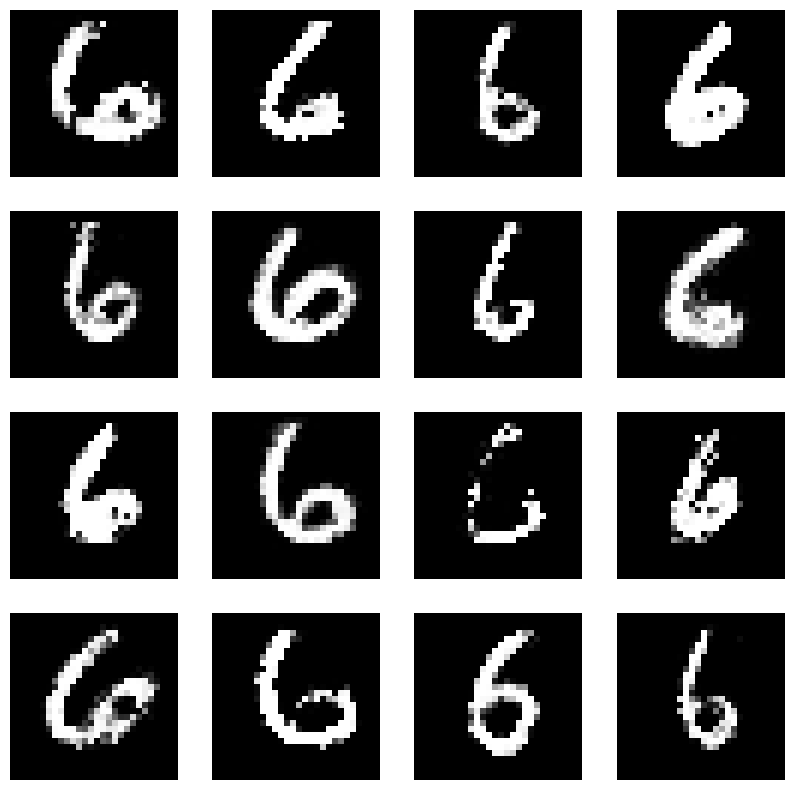

In [75]:
generate_images(saved_images)

In [55]:
CHANNEL_N = 16
SEED_STD = 0.1
CELL_FIRE_RATE = 0.5
target_digit = 0

In [56]:
#@title CA model and utils
def to_greyscale(x):
    y = tf.clip_by_value(x[..., 0:1], 0.0, 1.0)
    return y

def get_living_mask(x):
    alpha = x[:, :, :, 0:1]
    return tf.nn.max_pool2d(alpha, 3, [1, 1, 1, 1], 'SAME') > 0.1

def make_seed(num_examples, channel_n=CHANNEL_N, seed_std=SEED_STD):
    h, w = 28,28
    seed = np.zeros([num_examples, h, w, channel_n], np.float32)
    for i in range(h//2 - 1, h//2 + 1):
        for j in range(w//2-1, w//2 + 1):
            seed[:, i, j, 0] = np.random.uniform(1, 1, size = num_examples)
            seed[:, i, j, 1:] = np.random.normal(0, seed_std, size = seed[:, i, j, 1:].shape)
    return seed

# Gaussian initialization
class CustomInitializer(Initializer):
    def __init__(self, mean=0.0, stddev=0.01):
        self.mean = mean
        self.stddev = stddev

    def __call__(self, shape, dtype=np.float32):
        return tf.random.normal(shape, mean=self.mean, stddev=self.stddev, dtype=dtype)

class build_generator(tf.keras.Model):

    def __init__(self, channel_n=CHANNEL_N, fire_rate=CELL_FIRE_RATE):
        super().__init__()
        self.channel_n = channel_n
        self.fire_rate = fire_rate

        self.perceive = tf.keras.Sequential([
            Conv2D(100, 3, activation=tf.nn.relu, padding="SAME"), # 80 filters, 3x3 kernel
        ])

        self.dmodel = tf.keras.Sequential([
            Conv2D(256, 1, activation=tf.nn.relu),
            Conv2D(self.channel_n, 1, activation=tf.nn.tanh,
                kernel_initializer=tf.zeros_initializer),
        ])

        self(tf.zeros([1, 3, 3, channel_n]))  # dummy call to build the model

    @tf.function
    def call(self, x, fire_rate=None, angle=0.0, step_size=1.0):
        pre_life_mask = get_living_mask(x)

        y = self.perceive(x)
        dx = self.dmodel(y)*step_size
        if fire_rate is None:
            fire_rate = self.fire_rate
        update_mask = tf.random.uniform(tf.shape(x[:, :, :, :1])) <= fire_rate
        x += dx * tf.cast(update_mask, tf.float32)

        post_life_mask = get_living_mask(x)
        life_mask = pre_life_mask & post_life_mask

        return x * tf.cast(life_mask, tf.float32)

build_generator().dmodel.summary()

# TODO: TRY SIGMOID, square root loss 

Model: "sequential_49"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_73 (Conv2D)          (1, 3, 3, 256)            25856     
                                                                 
 conv2d_74 (Conv2D)          (1, 3, 3, 16)             4112      
                                                                 
Total params: 29968 (117.06 KB)
Trainable params: 29968 (117.06 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [72]:


model = build_generator()
model.summary()
checkpoint_path = "model_weights/tuples"
model.load_weights(checkpoint_path)

Model: "build_generator_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_52 (Sequential)  (1, 3, 3, 100)            14500     
                                                                 
 sequential_53 (Sequential)  (1, 3, 3, 16)             29968     
                                                                 
Total params: 44468 (173.70 KB)
Trainable params: 44468 (173.70 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


ValueError: Received incompatible tensor with shape (64,) when attempting to restore variable with shape (16,) and name conv2d_80/bias:0.

In [77]:
x = make_seed(16, channel_n=CHANNEL_N, seed_std=0.1)
for i in range(250):
    x = model(x, training=False) 
generated_images = x
fig, axes = plt.subplots(4, 4, figsize=(10, 10))  # 4x4 grid with larger size
greyscale_images = to_greyscale(generated_images)
for i, ax in enumerate(axes.flatten()):  # Flatten the 2D axes array
    ax.imshow(greyscale_images[i, :, :, 0], cmap='gray')
    ax.axis('off')  # Remove axes

In [30]:
print(", Tensor shape:", ckpt.get_tensor(name).shape)

ValueError: Couldn't find 'checkpoint' file or checkpoints in given directory model_weights/